# Relevant ML Topics

## Bias-Variance decomposition

#### Concept
To illustrate the concept of the bias-variance decomposition of the generalization error, we will first try to model the following function:
\begin{equation}
f(x)=sin(\pi x)
\end{equation}

From the first lecture, we assume that the observations $y$ follow the following distribution:
\begin{equation}
y=f(x) + \mathcal{N}(0,\sigma^2)
\end{equation}

Let us generate some data that meet our assumptions:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd
from sklearn import linear_model
import math
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

np.random.seed(5)

In [163]:
N = 10; 
x = 2*(np.random.rand(N, 1) -0.5)
xGrid = np.linspace(-1,1,100)

In [164]:
def f(x):
    y = 2*np.sin(math.pi*x)
    return y

In [ ]:
f_x = f(xGrid)
plt.plot(xGrid,f_x)

sigma = 0.2
y = f(x) + sigma*np.random.randn(len(x),1)

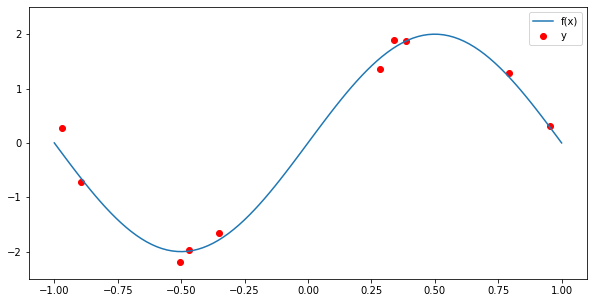

In [167]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(x,y, c='r')
plt.legend(['f(x)', 'y'])
plt.ylim(-2.5,2.5)
plt.show()

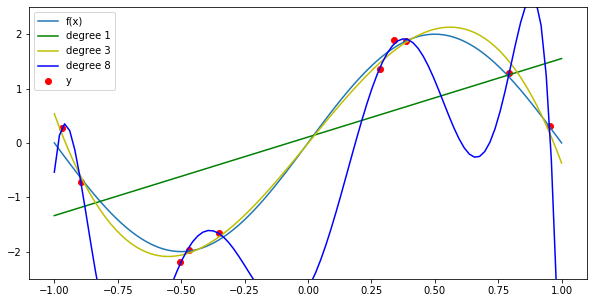

In [168]:
degree = [1,3,8]
plt.plot(xGrid,f_x)
xGrid = xGrid.reshape(len(xGrid),1)
plt.scatter(x,y, c='r')
colors=['g','y', 'b']
count = 0
#xGrid = xGrid.reshape(len(xGrid),1)
for a_degree in degree:
    poly = PolynomialFeatures(degree=a_degree)
    x_ = poly.fit_transform(x)
    predict_ = poly.fit_transform(xGrid)
    clf = linear_model.LinearRegression()
    clf.fit(x_, y)
    y_hat = clf.predict(predict_)
    plt.plot(xGrid,y_hat, color=colors[count], label='degree: ' + str(a_degree))
    count += 1
plt.legend(['f(x)'] + ['degree ' + str(x) for x in degree] + ['y'] )
plt.ylim(-2.5,2.5)
plt.show()

To get an idea of how each of the estimators above performs in general we can repeat the model fitting procedure for many data sets.

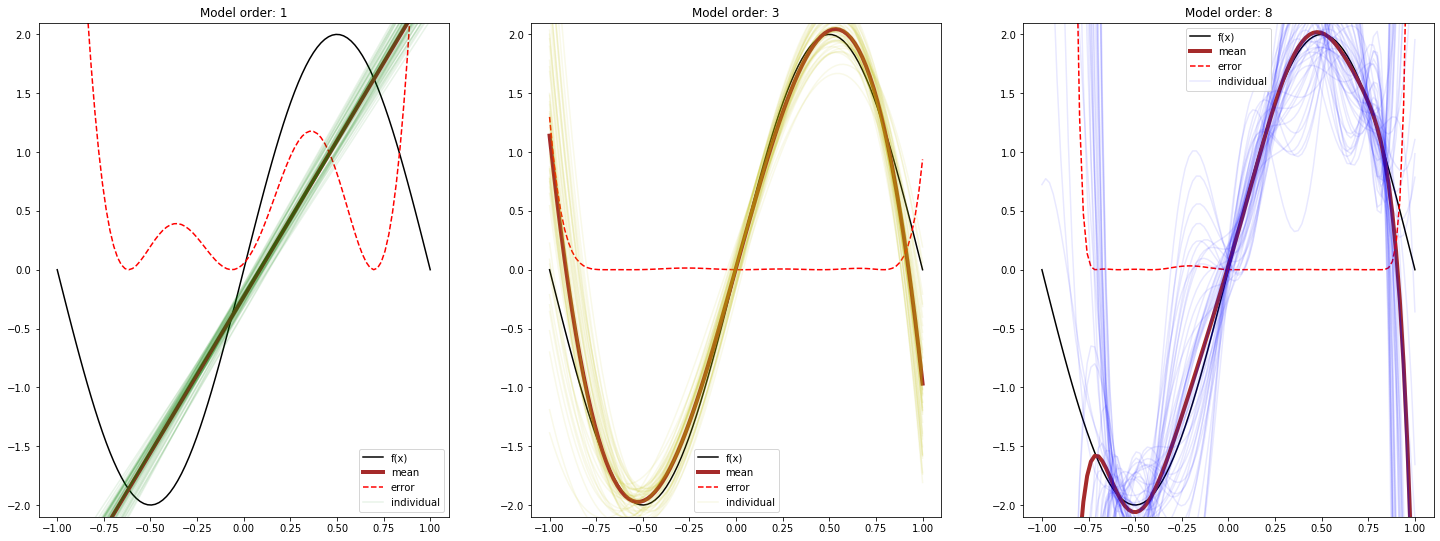

In [7]:
#FIT MODELS TO K INDEPENDENT DATASETS
plt.rcParams['figure.figsize'] = [25, 20]
K = 50;
empty=[np.zeros((K,len(xGrid))) for i in range(0,len(degree))] 
simulation= dict(zip(degree,empty))
for iS in range(0,K):
    ySim = f(x) + sigma*np.random.randn(len(x),1)
    for a_degree in degree:
        poly = PolynomialFeatures(degree=a_degree)
        x_ = poly.fit_transform(x)
        predict_ = poly.fit_transform(xGrid)
        clf = linear_model.LinearRegression()
        clf.fit(x_, ySim)
        y_hat = clf.predict(predict_)
        simulation[a_degree][iS,:]=np.squeeze(y_hat) 

for count, a_degree in enumerate(degree):
    ax1 = plt.subplot(231+count)
    ax1.plot(xGrid,f_x, color='black')
    ax1.plot(xGrid,np.mean(simulation[a_degree],0), color='brown',linewidth=4, label='mean')
    
    squared_error = (np.mean(simulation[a_degree],0) - np.squeeze(f_x))**2
    ax1.plot(xGrid,squared_error, color='red', linestyle='--')
    
    for iS in range(0,K):
        ax1.plot(xGrid,simulation[a_degree][iS,:],color=colors[count], alpha=0.09)
    ax1.legend(['f(x)', 'mean', 'error', 'individual'])
    ax1.set_title('Model order: ' + str(a_degree))

    plt.ylim(-2.1,2.1)
plt.show()

**Question**: What can you say about the variance of each model? their bias? is any model overfitting? underfitting?

#### Generalization error decomposition
Now let us do another set of experiments

In [52]:
N = 25 #Observations per dataset
K = 100 # number of datasets 
sigma = .5 #noise std_dev
n_train = math.ceil(N*.9); # size of training set
poly_order = 12 #max model complexity

In [155]:
x = np.linspace(-1,1,N)
x = x[np.random.permutation(N)]
x = x.reshape(N,1)

x_train = x[0:n_train]
x_test = x[n_train:] 
y_truth=f(x_test)
degrees = [i for i in range(1,poly_order+1)]

simulation_test=dict(zip(degrees,[np.zeros((K,(N-n_train))) for i in range(0,poly_order)]))
simulation_train=dict(zip(degrees,[np.zeros((K,(n_train))) for i in range(0,poly_order)] ))

error_test=dict(zip(degrees,[(K)*[0] for i in range(0,poly_order)]))
error_train=dict(zip(degrees,[(K)*[0] for i in range(0,poly_order)]))
   
for iS in range(0,K):
    y_sim = f(x) + sigma*np.random.randn(len(x),1)
    
    #training set
    y_train = y_sim[0:n_train]
 
    #test set
    y_test = y_sim[n_train:]
    
   # print(iS, y_test)
    for order in range(1,poly_order+1):
        poly = PolynomialFeatures(degree=order)
        x_ = poly.fit_transform(x_train)
        predict_ = poly.fit_transform(x_test)
        clf = linear_model.LinearRegression()
        clf.fit(x_, y_train)
        y_hat_test = clf.predict(predict_)
        y_hat_train = clf.predict(x_)

        #Store predictions
        simulation_test[order][iS,:]=np.squeeze(y_hat_test) 
        simulation_train[order][iS,:]=np.squeeze(y_hat_train) 

        #Mean squared error
        error_test[order][iS] = np.mean((np.squeeze(y_hat_test) - np.squeeze(y_test))**2)
        error_train[order][iS] = np.mean((np.squeeze(y_hat_train) - np.squeeze(y_train))**2)


train_error = [np.mean(error_train[order]) for order in range(1,poly_order+1)]
test_error = [np.mean(error_test[order]) for order in range(1,poly_order+1)]
variance = [np.mean(np.var(simulation_test[order],0)) for order in range(1,poly_order+1)] 
bias_sq = [np.mean((np.mean(simulation_test[order],0) - y_truth)**2) for order in range(1,poly_order+1)]

best_model = np.argmin(test_error)

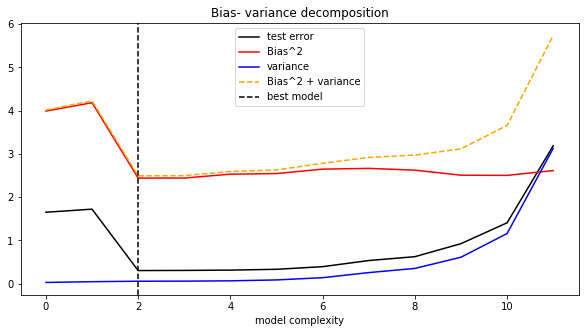

In [169]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(test_error, color='k')
plt.plot(bias_sq, color='r')
plt.plot(variance, color='b')

plt.plot(np.array(bias_sq) + np.array(variance), color='orange', linestyle='--')
plt.axvline(x=best_model, linestyle='--', color='k')

plt.legend(['test error', 'Bias^2', 'variance', 'Bias^2 + variance', 'best model'])
plt.xlabel('model complexity')
plt.title('Bias- variance decomposition')
plt.show()

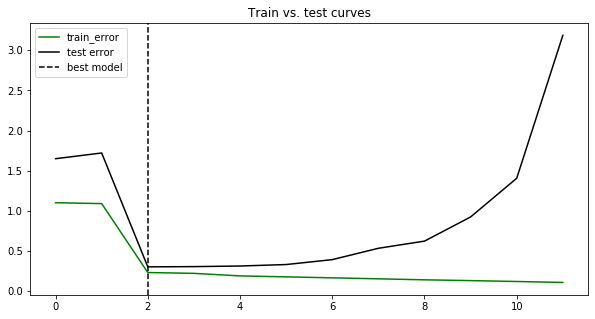

In [162]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(train_error,color='g')
plt.plot(test_error,color='k')
plt.axvline(x=best_model, linestyle='--', color='k')

plt.legend(['train_error', 'test error', 'best model'])
plt.title('Train vs. test curves')
plt.show()

## Regularization

#### Regularization as a way to do feature selection
In this part, we illustrate the concept of regularization as seen during the lecture

In [3]:
data_folder = '/home/lasdonnas/data/malis/'

In [308]:
#1- Data loading - We use the prostate cancer data set from The Elements of Statistical learning
ds= pd.read_csv(data_folder + 'prostate.csv')
ds.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,True
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,True
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,True
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,True
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,True


In [309]:
#Following the procedure from the book, we use the same training/testing datasets as they do
ds_train = ds[ds['train'] == True]
ds_test = ds[ds['train'] == False]

In [31]:
#Split data (X) from targets (y)
x_train = ds_train.iloc[:,[0,1,2,3,4,5,6,7]]
y_train = ds_train['lcavol']

In [314]:
from numpy.linalg import inv
from numpy import linalg

def ridge_regression(X,y, lambda_val):
    '''Naive implementation of ridge regression that illustrated the introduction of the regularization term'''
    X_t = np.transpose(X) #X^T
    X_t_X = X_t.dot(X)    #X^TX
    
    reg_term = lambda_val*np.identity(len(X_t_X))    

    X_inv = inv(X_t_X + reg_term)    #(#X^TX + lambda*I)^-1
    X_T_y = X_t.dot(y)    #X^Ty
    w = linalg.solve(X_t_X + reg_term, X_T_y)
    return w

Recall that the regularization acts over all the model parameters except for $w_0$. In order to do matrix operations (rather than element-wise sums), there are two possible tricks:

1. Manually set to zero the first element of the identity matrix
2. (Better) Centering and normalizing the data so that the effect of the intercept (or bias) is not so relevant.

Below we use option 2.

In [316]:
y_train_norm = y_train - y_train.mean()

norm = (np.square(x_train)).sum(axis=0)
x_train_norm = (x_train - x_train.mean())/np.sqrt(norm)

poly = PolynomialFeatures(1)  
x_train_norm = poly.fit_transform(x_train_norm)

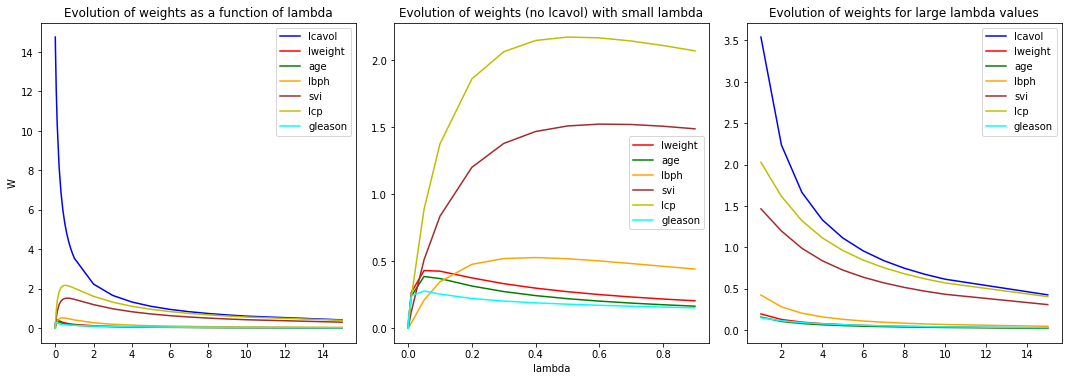

In [327]:
lambda_range=[0.00, 0.0001,0.0005, 0.001, 0.01, 0.05, 0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,2,3,4,5,6,7,8,9,10,15] 

results = np.ndarray(shape=(len(lambda_range),8), dtype=float)
df = np.ndarray(shape=(len(lambda_range),1), dtype=float)
counter = 0
for a_lambda in lambda_range:
    w_hat= ridge_regression(x_train_norm, y_train_norm, a_lambda)
    results[counter,:] =  w_hat[1:]    
    #print(w_hat)
    counter +=1
       
plt.rcParams['figure.figsize'] = [15, 10]
colors=['b','r', 'g', 'orange', 'brown', 'y', 'cyan']
plt.subplot(231) 
for feat in range(0,7):
    plt.tight_layout()
    plt.plot(lambda_range,results[:,feat],  color=colors[feat], label=x_train.columns.values[feat])
    plt.legend()
plt.ylabel('W')
plt.title('Evolution of weights as a function of lambda')

plt.subplot(232) 
part_1=15
for feat in range(1,7):
    plt.tight_layout()
    plt.plot(lambda_range[:part_1],results[:part_1,feat],  color=colors[feat], label=x_train.columns.values[feat])
    plt.legend()
plt.title('Evolution of weights (no lcavol) with small lambda')
plt.xlabel('lambda')
plt.subplot(233) 
for feat in range(0,7):
    plt.tight_layout()
    plt.plot(lambda_range[part_1:],results[part_1:,feat],  color=colors[feat], label=x_train.columns.values[feat])
    plt.legend()
plt.title('Evolution of weights for large lambda values')

plt.show()

## Model Selection
In this last section, we illustrate how model selection can be interpreted as a mechanisim to do feature selection. For that purpose, we will use the diabetes dataset (from UCI repository).

**Exercise:** Do a proper implementation of cross-validation (train/validation/test). How do your results look like? Use a regularization technique such as Lasso. Are your results similar?


In [170]:
from sklearn import datasets
import pandas as pd

In [201]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
feats = diabetes.feature_names

df = pd.DataFrame(X, columns = feats) 
df['target'] = y

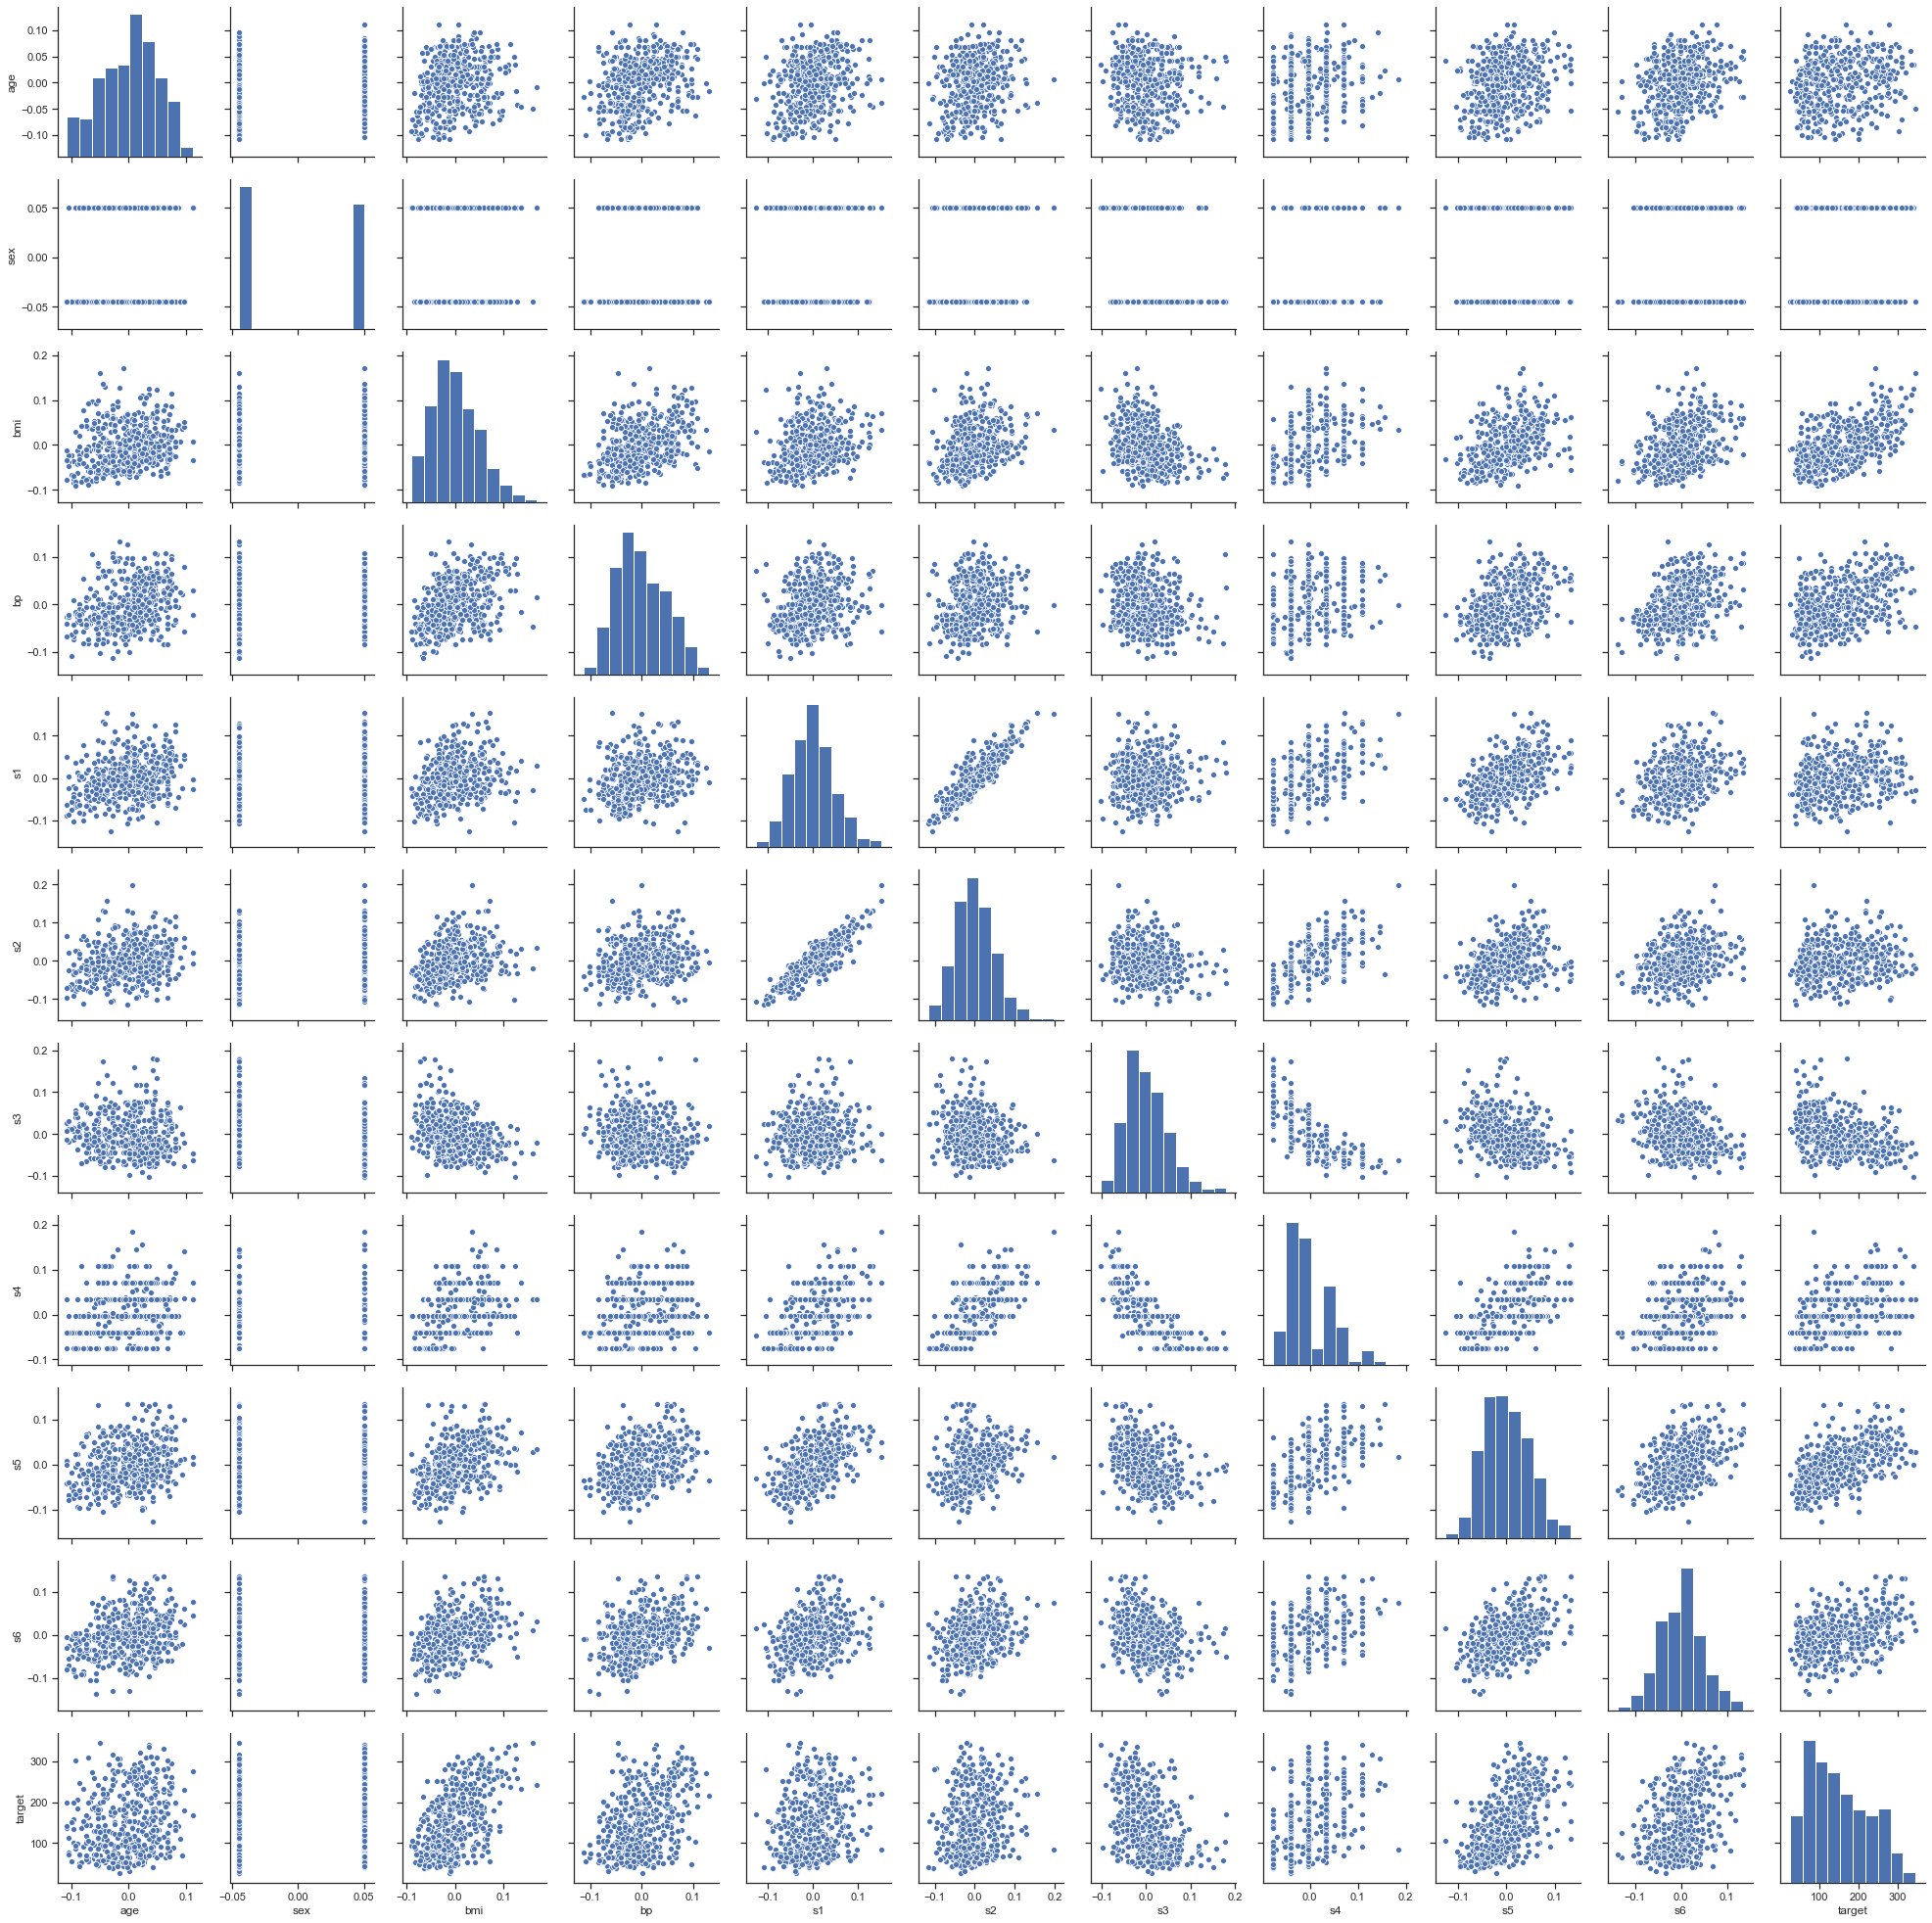

In [200]:
#another tool to plot scatterplot matrices
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df)

In [277]:
#Simple data split: Exercise - Do a proper split of the data and perform a nested cross-validation to 
#determine the good feature set 
from sklearn.utils import shuffle
df = shuffle(df)

folds = np.array_split(df, 2)
y_train = folds[0]['target'].values
y_test = folds[1]['target'].values
X_train = folds[0]
X_test = folds[1]

In [278]:
sets = {'all': ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
        'bmi': ['bmi'],
        's5': ['s5'], 
        's6': ['s6'], 
        's4': ['s4'], 's3': ['s3'],
        's6-5': ['s6','s5'], 
        'bmi-s5': ['bmi', 's5'], 
          's3-s4': ['s3', 's4']}

print('features |          train loss     |     test loss')
print('********************************************************')
for key in sets.keys():
    x_train = X_train[sets[key]]
    x_test = X_test[sets[key]]

    clf = linear_model.LinearRegression()
    clf.fit(x_train, y_train)
    y_hat_test = clf.predict(x_test)
    y_hat_train = clf.predict(x_train)

    mse_test = np.sum((y_hat_test - y_test)**2)/len(y_test)
    mse_train = np.sum((y_hat_train - y_train)**2)/len(y_train)
    print(key, '      ', mse_train, '        ', mse_test)

features |          train loss     |     test loss
********************************************************
all        2738.3222634520125          3059.2946540587254
bmi        3775.992010195097          4006.076948532435
s5        3875.2689289247546          4200.375109147454
s6        4757.791559937881          5415.9299154032815
s6-5        3655.8517566964583          4232.089495904753
bmi-s5        3050.7914578322916          3374.034758866552
s4        4871.7807674362775          4792.15625146854
s3        5241.765894284398          4777.891926278767
s3-s4        4845.186641989437          4691.858049376679
